# Simulated Wave Pool

* To get started: Hit Shift-Enter repeatedly until you arive at the last cell
* Then: Start playing with/modifying different pieces. Hit Ctrl-Enter to the end to re-run the code.
* Every cell that's not marked as inscrutable is meant to be understood, at least at some level.

In [1]:
# (inscrutable setup mumbo-jumbo)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from numba import jit as execute_quickly
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def show_field(f, **kwargs):
    return plt.imshow(f[:, ::-1].T, extent=(x[0,0], x[-1, 0], y[0, 0], y[0, -1]), **kwargs)

In [2]:
x, y = np.mgrid[-1:3:500j, -1.5:1.5:250j]

dx = x[1,0] - x[0,0]
dy = y[0,1] - y[0,0]

dt = 0.5 * min(dx, dy)

In [3]:
# point source
#source_shape = np.exp(-500*(x**2+y**2))

# plane wave
source_shape = np.exp(-1000*((x--0.5)**2)) * (1-np.tanh(np.abs(y) - 0.95))

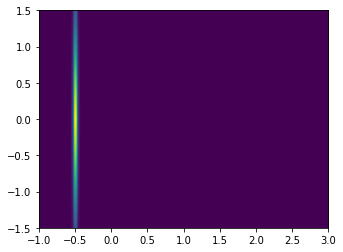

In [4]:
show_field(source_shape)

In [17]:
def make_geometry(x_pos, slit_width):
    global is_free_space
    # parabolic reflector
    # is_free_space = x - y**2 + 0.7 > 0

    # single slit
    # is_free_space = (np.abs(x-1) > 0.02) | (np.abs(y) < 0.04)

    # double slit
    is_free_space = (np.abs(x-x_pos) > 0.02) | (np.abs(y - 0.2) < slit_width/2) | (np.abs(y + 0.2) < slit_width/2)

    # "pebbles"
    # is_free_space = (np.sin(5* x)*np.sin(5 * y) + 0.2) > 0

    show_field(is_free_space)

interact(make_geometry,
            x_pos=widgets.FloatSlider(min=-1, max=3, step=0.05, value=0),
            slit_width=widgets.FloatSlider(min=0, max=0.25, step=0.001, value=0.04),
            )

interactive(children=(FloatSlider(value=0.0, description='x_pos', max=3.0, min=-1.0, step=0.05), FloatSlider(v…

<function __main__.make_geometry(x_pos, slit_width)>

This next cell says:

* The restoring force acting on the wave surface is proportional to the "bendiness" of the surface.

* "Bendiness" is measured by the second derivative

* The second derivative is approximated using so-called [finite differences](https://en.wikipedia.org/wiki/Finite_difference#Higher-order_differences)

In [18]:
@execute_quickly
def bendiness(f, dx, dy):
    result = np.zeros_like(f)
    
    m, n = f.shape
    for i in range(1, m-1):
        for j in range(1, n-1):
            result[i, j] = (
                # 
                  1/dx**2 * (f[i-1,j] - 2*f[i,j] + f[i+1,j])
                + 1/dy**2 * (f[i,j-1] - 2*f[i,j] + f[i,j+1])
                )
            
    return result * is_free_space

In [19]:
ntimes = 600
nvideo_frames = 100

fields_for_video = np.empty((nvideo_frames,) + x.shape)

field = np.zeros_like(source_shape)
velocity = np.zeros_like(source_shape)

for i in range(ntimes):
    t = i * dt
    fields_for_video[i//(ntimes//nvideo_frames)] = field
    
    field = field + dt * velocity + dt * np.sin(100 * t) * source_shape
    velocity += dt * bendiness(field, dx, dy)

In [20]:
# inscrutable video rendering mumbo-jumbo - execute to see video
# This is yucky and not intended for the students to mess with/understand.

fig = plt.figure(figsize=(10, 7))

vmax = np.max(np.abs(fields_for_video)) * 0.05
img = show_field(source_shape, vmax=vmax, vmin=-vmax)
    
boundary = (1-is_free_space) * 200

def animate(i):
    img.set_data((fields_for_video[i] - boundary)[:, ::-1].T)
    return (img,)

anim = animation.FuncAnimation(
    fig, animate, frames=nvideo_frames, interval=50, blit=True)

from IPython.display import HTML
html = HTML(anim.to_html5_video())
plt.clf()

html